### Initialization

#### A little magick
The file `01.css` contains some `CSS` directives to be applied to the
styling of the notebook and the following _displays_ it so that the
browser is aware of it.

In [1]:
from IPython.display import display, HTML
display(HTML(open('01.css').read()))

#### The main libraries, plus ...
We start with loading a library for symbolic manipulation (`sympy`) and one for
numerical/array oriented computations (`numpy`), plus a root finding function (`newton`).

In [2]:
import sympy as sp
import numpy as np
from scipy.optimize import  newton
sp.init_printing(use_latex=True)

### Matplotib

We need just a submodule of `matplotlib`, the command `%matplotlib
inline` directs the notebook to render all the plots inlined in the
output cells, then we set a style and modify some of its defaults.

In [3]:
# %matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
plt.rcParams['figure.dpi'] = 118
plt.rcParams['figure.figsize'] = (7.0, 3.0)
plt.rcParams['axes.grid'] = True

I want to compare successive approximations (partial sums) to response quantities and initially I've done it in the main program, but realizing that I was repeating the same things too many times  decided to put the boring details in the `plot_cum` function.

In [4]:
def plot_cum(*, what=[], position=0, label=None, title=None, fname=None):
    from numpy import cumsum, diag, pi
    import matplotlib.pyplot as plt
    vals = [float(what[i].subs(xi, position).evalf()) for i in range(Nfun)]
    approxs = cumsum(diag(vals)@etai, axis=0)

    display(HTML('<h3>'+title+'</h3>'))
    for i, (worse, better) in enumerate(couples(approxs), 1):
        plt.plot(a/pi, worse,
                 color='k', label=label%(i+0), linewidth=1.8, alpha=0.4)
        plt.plot(a/pi, better,
                 color='r', label=label%(i+1), linewidth=0.6, alpha=1.0)
        plt.xlabel(r'$\omega_0 t/\pi$')
        plt.legend()
        plt.tight_layout()
        if fname: plt.savefig('figures/'+fname+'%2.2d.pdf'%(i+1))
        plt.show()

#### Utilities

We need one additional library function, then we can define `ld` to simplify the generation of mathematical displays, `align` to further simplify that.

`couples` returns successive couples from a sequence of objects, like
`couples((1, 2, 3, 4)) -> (1, 2), (2, 3), (3,4)` and we have already used it in the definition of `plot_cum`.

In [5]:
from IPython.display import Latex

def ld(*li): 
    display(Latex(' '.join(li)))
    
def align(iterable):
    ld(r'\begin{align}', r'\\'.join(iterable), r'\end{align}')

def couples(iterable):
    from itertools import tee
    a, b = tee(iter(iterable))
    next(b, None)
    return zip(a, b)

# Response of a uniform beam

In [6]:
display(HTML(open('figures/trab2_conv.svg').read()))

An undamped, uniform beam of length $L$,  unit mass $\bar m$ and
flexural stiffness $EJ$ is clamped at one end and it is free at the
other one.

The beam is at rest when it is excited by a dynamic load,
$$p(x, t) = p_0 \begin{cases}
    \sin(3\pi x/L) \sin(9\omega_0t) &
              \text{for }0 \le \omega_0 t \le\frac{2}{3}\pi\\
    0 & \text{otherwise.}
\end{cases}$$
where $\omega_0^2 =\frac{EJ}{\bar mL^4}$.

1. Compute an approximation of the tip displacement, $v(L, t)$ using
   the first 3 modes of vibration and plot your results (normalized
   with respect to $\frac{p_0L^4}{EJ}$) in the time interval $0 \le t
   \le \frac{2\pi}{\omega_0}$.
   
2. Compute an approximation to the bending moment at the clamped end,
   $M(0, t)$ using the first 3 modes of vibration and plot your
   results (normalized with respect to $p_0L^2$) in the same time
   interval.

## Masterplan

1. First of all, we must determine the eigenfunctions that respect the
   boundary conditions as well as the corresponding wave-numbers and
   frequencies of vibration, optionally we can normalize the
   eigenfunction,

2. Next we must solve the equation of motion, using a modal expansion
   and the orthogonality properties of the eigenfunctions, for both
   the forced phase and the free vibration phase.  The steps involved
   comprise the determination of the modal masses and stiffnesses, the
   modal load components, the determination of the particular
   integrals and the determination of the homogeneous part of the
   response by imposing the initial condition, at the beginning of the
   excitation and at the beginning of the free vibrations.

3. Eventually we compute the required quantities ($v(L,t)$ and
   $M(0,t)$) and plot it as requested.

## Eigenvalues and eigenfunctions

Using separation of variables, $v(x, t) = \phi(x) q(t)$, the solution
of the infinitesimal equation of equilibrium for the free vibration of
an uniform beam is

In [7]:
A, B, C, D, L, lam, Lam, x, xi = sp.symbols('A B C D L lambda Lambda x xi')

phi0 = A*sp.sin(lam*x) + B*sp.cos(lam*x) + C*sp.sinh(lam*x) + D*sp.cosh(lam*x)

ld(r'\begin{multline}q(t) = R \cos\omega t + S \sin\omega t,\\',
   r'\phi(x)=', sp.latex(phi0), r'\\',
   r'\qquad\text{with } \omega^2=\frac{\lambda^4\,EJ}{m}.\end{multline}')

<IPython.core.display.Latex object>

### Boundary Conditions

To determine the constants of integration we have to impose that the solution respects the boundary conditions.

#### Geometric Conditions

First the constraints for $x=0$: $\quad\phi(0)=0$ and $\phi'(0)=0$.

In [8]:
eq1 = phi0.subs(x, 0)
eq2 = phi0.diff(x).subs(x, 0)
ld('$$', sp.latex(eq1), r'=0,\qquad', sp.latex(eq2), '=0.$$')

<IPython.core.display.Latex object>

We solve for $C, D$ in terms of $A, B$ 

In [9]:
sol0 = sp.solve((eq1, eq2), (C, D))
display(sol0)

and substitute in the general solution

In [10]:
phi0 = phi0.subs(sol0)
ld(r'$$\phi = ', sp.latex(phi0), '$$')

<IPython.core.display.Latex object>

#### Natural Conditions

For $x=L$ the shear and the bending moment must be equal to zero, that is equivalent to
$\phi'''(L)=0$ and $\phi''(L)=0$.

In [11]:
eq1 = (phi0.diff(x, 2).subs(x, L))
eq2 = (phi0.diff(x, 3).subs(x, L))

coeffs = sp.Matrix(
    [[eq.diff(var).expand() for var in (A, B)] for eq in (eq1, eq2)])

ld(r"$$\begin{Bmatrix}\phi''(L)\\\phi'''(L)\end{Bmatrix} = ",
    sp.latex(coeffs),
    r'\begin{Bmatrix}A\\B\end{Bmatrix} = \begin{Bmatrix}0\\0\end{Bmatrix}$$')

<IPython.core.display.Latex object>

### Zero out the determinant
To have a non trivial solution to the homogeneous system above, the determinant of the matrix of coefficients (a function of $\lambda L$) must be put equal to zero.

In [12]:
det = coeffs.det().trigsimp()
display(Latex('$$'+sp.latex(det)+'=0$$'))

<IPython.core.display.Latex object>

#### Visual representation of the roots

We rewrite the equation above as $\cos \lambda L = -1 / \cosh \lambda L$ and plot the two terms separately

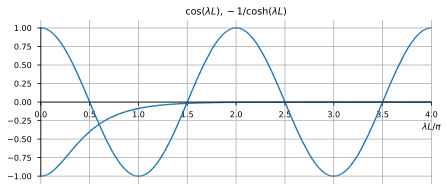

In [13]:
det = det.subs(L, Lam/lam).subs(lam,-1)

p = sp.plot(sp.cos(Lam*sp.pi), -1/sp.cosh(Lam*sp.pi), (Lam, 0, 4),
        xlabel=r'$\lambda L/\pi$', ylabel='',
        title=r'$\cos(\lambda L), -1/\cosh(\lambda L)$', show=0)
#p.save('figures/roots.pdf');
p.show()

The roots are more and more close to $(n-0.5)\pi$...

#### Numerical solution

We decide the number of eigenfunctons we want to deal with, `Nfun = 5`,
to compute numerically the roots we must convert the symbolic representations of the determinant to a numerical function, i.e., one that takes a numerical argument and returns a numerical value.

When we have performed these preliminaries, we can compute the roots $\Lambda_i = \lambda_iL$ for $i=1,\ldots,{}$`Nfun`.

In [14]:
Nfun = 5

f0 = sp.lambdify(Lam, det.subs(lam,-1))
f1 = sp.lambdify(Lam, det.diff(Lam).subs(lam,-1))
roots = []

print(' n             x0/pi (lambda_i L)/pi      lambda_i L         Delta %')
for i in range(Nfun):
    x0 = (0.5+i)*np.pi
    root = newton(f0, x0, f1) 
    print('%2d   %15.6f %15.6f %15.6f %15.6f'%(
        i+1, x0/np.pi, root/np.pi, root, 100*(root-x0)/x0))
    roots.append(root)
print(' '.join('%.6f'%r for r in roots))

 n             x0/pi (lambda_i L)/pi      lambda_i L         Delta %
 1          0.500000        0.596864        1.875104       19.372833
 2          1.500000        1.494176        4.694091       -0.388292
 3          2.500000        2.500247        7.854757        0.009878
 4          3.500000        3.499989       10.995541       -0.000305
 5          4.500000        4.500000       14.137168        0.000010
1.875104 4.694091 7.854757 10.995541 14.137168


#### Non normalized eigenfunctions

Using the first row of the linear system we compute $B_i$ in terms of $A_i$ and eventually we substitute $A_i = -(-1)^i$ so that all the tip displacements are positive (see plot below).

In [15]:
phi0s, coefs, pieces = [], [], []
for i in range(Nfun):    
    sol = sp.solve(eq1.subs(lam, roots[i]/L), B)[0]
    coef = sol.subs(A,1)
    sign = ['+', '-'][i%2]
    arg = r'(%10.4f\,\xi)'%roots[i]
    pieces.append(
        r'%s\phi_{%d}(\xi) &= \sin%s - \sinh%s %+f\,(\cos%s - \cosh%s)'%
       (sign, i+1, arg, arg, coef, arg, arg))
    tmp = phi0.subs({B:sol}).subs({lam:roots[i]/L, x:xi*L, A:1})*(-1)**i
    phi0s.append(tmp), coefs.append(coef)
ld(r'\begin{align*}', r'\\'.join(pieces), '\end{align*}')

<IPython.core.display.Latex object>

#### Normalized eigenfunctions

Compute the modal mass ans subsequently divide the eigenfunctions by the square root of it.

In [16]:
from scipy.integrate import  quad
pieces = []
for i, phi in enumerate(phi0s):
    mass_temp = quad(sp.lambdify(xi, phi**2), 0, 1)[0]
    fac = np.sqrt(mass_temp)
    phi0s[i] = phi0s[i]/fac
    fac = (-1)**i/fac
    lx = r'\Lambda_{%d}\xi'%(i+1)
    pieces.append(
        r'\phi_{%d} &= %+.6f(\sin%s-\sinh%s)%+.6f(\cos%s-\cosh%s)' %
       (i+1, fac, lx, lx, coefs[i]*fac, lx, lx))
ld(r'\begin{align}', r'\\'.join(pieces), r'\end{align}')

<IPython.core.display.Latex object>

#### Plotting the eigenfunctions

Note that, to any practical accuracy, $\phi_i(L) = 2$

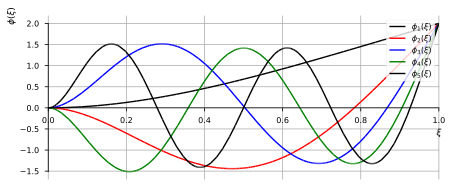

In [17]:
p = sp.plot(*phi0s, (xi, 0, 1), show=0, xlabel='$\\xi$', ylabel='$\\phi(\\xi)$')
for n, l in enumerate(p, 1):
    l.label = r'$\phi_{%d}(\xi)$'%n
    l.line_color = ['k', 'r', 'b', 'g'][(n-1)%4]
p.legend=True
#p.save('figures/eigfuns.pdf');
p.show()

and, on the same scale, plot the spatial dependency of the loading

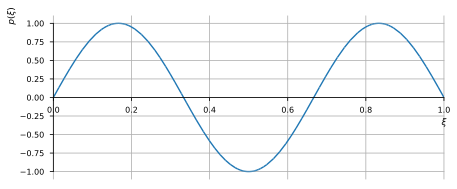

In [18]:
p = sp.plot(sp.sin(3*sp.pi*xi), (xi, 0, 1),
            xlabel=r'$\xi$', ylabel=r'$p(\xi)$', show=0)
#p.save('figures/load2xi.pdf');
p.show();

(note the similarity between the spatial distribution of the load and $\phi_4$).

## The equation of motion

Using separation of variables, with $m$ being the mass per unit of length, $p_0$ a load per unit of length
and $p(x),\;f(t)$ being adimensional functions we can write

$$ m \left(\sum \phi_j\ddot q_j\right) +
  EJ \left(\sum \phi_j'''' q_j\right) = p_0\,p(x)\,f(t)
$$

multiplying by $\phi_i$, integrating, taking into account the eigenfunctions orthogonality and taking into account the identities $x = L\xi$, $dx = L\,d\xi$ and $\phi''''(x) = \phi''''(\xi)/L^4$
the equation of motion is transformed in a set of uncoupled ordinary differential equations

\begin{multline}
   mL \cdot \int_0^1\phi_i^2(\xi)\,d\xi \cdot \ddot q + 
   \frac{EJ}{L^3} \cdot \int_0^1 \phi_i(\xi)\phi_i''''(\xi)\,d\xi \cdot q = \\
   = p_0 L\cdot \int_0^1 \phi_i(\xi)p(\xi)\,d\xi \cdot f(t),\qquad i=1,\ldots,\infty
\end{multline}

or

$$ m_0 \cdot m_i \cdot \ddot q_i + k_0 \cdot k_i \cdot q_i = P_0 \cdot p_i \cdot f(t) $$

where $m_0 = m L$, ${}\,k_0 = (EJ)/(L^3)$, ${}\,P_0 = p_0 L$ and

\begin{align*}
  m_i &= \int_0^1\phi_i^2(\xi)\,d\xi = 1 \text{ (we have mass-normalized the eigenfunctions)}\\
  k_i &= \int_0^1 \phi_i(\xi)\phi_i''''(\xi)\,d\xi \\
  p_i &= \int_0^1 \phi_i(\xi)p(\xi)\,d\xi \\
  \\
 \end{align*}

#### Modal masses, modal stiffnesses

Just to be sure, recompute also the modal masses

In [19]:
ms, ks = [], []
print('n          M_n             K_n        omega^2_n        beta^4_n') 
for i, phi in enumerate(phi0s):
    ms.append(quad(sp.lambdify(xi, phi**2), 0, 1)[0])
    ks.append(quad(sp.lambdify(xi, (phi.diff(xi, 2))**2), 0, 1)[0])
    print('%d   %10.6f %15.6f  %15.6f %15.6f '%
          (i+1, ms[i], ks[i], ks[i]/ms[i], roots[i]**4))
ld('$', 
   r', \quad '.join('k_{%d}=%.6f'%(i+1,ks[i]) for i in range(Nfun)),
   r'.$')


n          M_n             K_n        omega^2_n        beta^4_n
1     1.000000       12.362363        12.362363       12.362363 
2     1.000000      485.518819       485.518819      485.518819 
3     1.000000     3806.546266      3806.546266     3806.546266 
4     1.000000    14617.273305     14617.273305    14617.273305 
5     1.000000    39943.831784     39943.831779    39943.831779 


<IPython.core.display.Latex object>

#### Modal load components
Note that the modal load for mode no. 4 is the larger one, as expected.

In [20]:
pis = [quad(sp.lambdify(xi, sp.sin(3*sp.pi*xi)*phi), 0, 1)[0] for phi in phi0s]
ld('$$', r',\quad'.join(' p_{%d} = %+f' % (i, pi) 
                        for i, pi in enumerate(pis, 1)),'.$$')

<IPython.core.display.Latex object>

#### Plot of the load time dependency

The load consists of three complete cycles

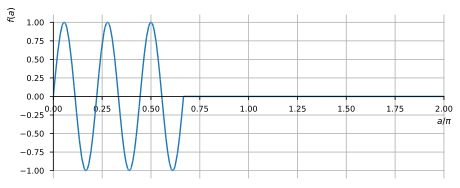

In [21]:
p = sp.plot((sp.sin(9*x*sp.pi), (x, 0, 2/3)), (0, (x, 2/3, 2)), 
        xlabel='$a/\\pi$', ylabel='$f(a)$', show=0)
#p.save('figures/load2a');
p.show()

### Eq. of motion, cont.

Dividing by $m_0$, with $k_0/m_0 = \omega^2_0$ 

$$   m_i \cdot \ddot q_i + k_i \cdot \omega_0^2 q_i = 
     \frac{k_0}{m_0} \frac{P_0}{k_0} \cdot p_i \cdot f(t) =
     \omega_0^2 \Delta_\text{st} \cdot p_i \cdot f(t).$$
     
Using an adimensional time coordinate $a = \omega_0 t$ we have $\ddot q(t) = \omega_0^2 \ddot q(a)$ and it is hence possible to remove the dependency on $\omega_0^2$:

$$m_i \ddot q_i(a) + k_i q_i(a) = \Delta_\text{st} p_i f(a).$$

Introducing an adimensional modal response function $\eta(a) = q(a)/\Delta_\text{st}$m the modal equations of motion can be written

$$m_i \ddot \eta_i(a) + k_i \eta_i(a) = p_i f(a)$$

and the response is

$$v(x, t) = \Delta_\text{st} \, \sum \phi_i(x) \eta_i(t). $$

Taking into account that $m_i \equiv 1$ we can write, for $0 \le a \le 2\pi/3$

In [22]:
align("%+10f \cdot \eta_{%d} + \ddot \eta_{%d} &= %+10.7f \cdot \sin 9a"
                 %(ks[i], i+1, i+1, pis[i]) for i in range(Nfun))

<IPython.core.display.Latex object>

while for $2\pi \le a$ the load is zero and we have free vibrations.

Using the positions $\psi_0=9$ and $\psi_i^2=k_i$, substituting a particular integral $\xi_i(a) = C_i \sin \psi_0 a$ in the modal equations of motion we have

$$ (\psi_i^2 - \psi_0^2) \, C_i \sin \psi_0 a = p_i \sin \psi_0 a \rightarrow
   C_i = \frac{p_i}{\psi_i^2 - \psi_0^2}.$$

The homogeneous integral is $A_i \cos \psi_i a + B \sin\psi_i a$, taking into account the initial conditions $q_i(0)=0$, $\dot q_i(0)=0$ we have

$$ \eta_i = \frac{p_i}{\psi^2_i -\psi_0^2} \,
\left( \sin\psi_0a - \frac{\psi_0}{\psi_i}\sin\psi_ia\right),
\qquad\text{for } 0 \le a \le \frac{2}{3}\pi,
$$

$$ \dot \eta_i = \psi_0 \frac{p_i}{\psi^2_i -\psi_0^2} \,
\left( \cos\psi_0a - \cos\psi_ia\right).$$

In [23]:
psi_0, psi_i = 9.0, np.sqrt(ks)
Ci = pis/(psi_i**2-psi_0**2)
bi = psi_0/psi_i

align(r'1000\,\eta_{%d} &= %f(\sin(9.0 a)-%f\sin(%f a))'%
                       (i+1, Ci[i]*1000,bi[i],psi_i[i]) for i in range(Nfun))

<IPython.core.display.Latex object>

### Free response

The homogeneous integral is

$$ \eta_i = A_i \cos \psi_i a + B_i \sin \psi_i a,\qquad \frac23\pi \le a$$

the constants can be determined using continuity in $a= 2\pi/3$,

$$\begin{bmatrix}
  +\cos \psi_i a_1 & +\sin \psi_i a_1 \\
  -\sin \psi_i a_1 & +\cos \psi_i a_1
  \end{bmatrix}\, \begin{Bmatrix}A_i\\B_i\end{Bmatrix} =
  \begin{Bmatrix}\eta_i(a_1)\\\displaystyle\frac{\dot\eta_i(a_1)}{\psi_i}\end{Bmatrix}
$$

Because the coefficient matrix is orthogonal its transpose is its inverse and we can write

\begin{multline}
    A_i = +\cos \psi_i a_1 \eta_i(a_1) - \sin \psi_i a_1 \frac{\dot\eta_i(a_1)}{\psi_i},\\
    B_i = +\sin \psi_i a_1 \eta_i(a_1) + \cos \psi_i a_1 \frac{\dot\eta_i(a_1)}{\psi_i}.
\end{multline}

The straightforward implementation follows

In [24]:
a23 = np.pi*2/3

etai23 = Ci*(np.sin(psi_0*a23)-bi*np.sin(psi_i*a23))
detai23 = psi_0*Ci*(np.cos(psi_0*a23)-np.cos(psi_i*a23))

ci23 = np.cos(psi_i*a23)
si23 = np.sin(psi_i*a23)

Ai = np.diag(ci23*etai23 - si23*detai23/psi_i)
Bi = np.diag(si23*etai23 + ci23*detai23/psi_i)

align(r'1000\,\eta_{%d} &= %+f\cos%.4f a %+f\sin%.4f a'%
       (i+1, 1000*Ai[i,i], psi_i[i], 1000*Bi[i,i], psi_i[i]) for i in range(Nfun))

<IPython.core.display.Latex object>

### Numerical computation of the modal response

We produce an array with the time coordinate and write a conditional expression to stitch together the two phases (forced and free) of the modal responses.

In [25]:
nint = 9000
a = np.linspace(0, 2*np.pi, nint+1)
psi_a = np.outer(psi_i, a)
etai = np.where(a<=a23, np.diag(Ci)@(np.sin(psi_0*a[None,:]) - np.diag(bi)@np.sin(psi_a)),
                       Ai@np.cos(psi_a) + Bi@np.sin(psi_a))

#### Plotting the modal responses

Firstly we plot individually some of the modal responses, otherwise it'd be difficult to appreciate the details, due to the different scales involved.

For each of the modes, we plot a short interval following the start of the response to verify that we have zero displacements and zero velocity, and a short interval around $a_1=2\pi/3$, where we have the discontinuity of the load but we expect no discontinuities neither in displacements nor in velocities.

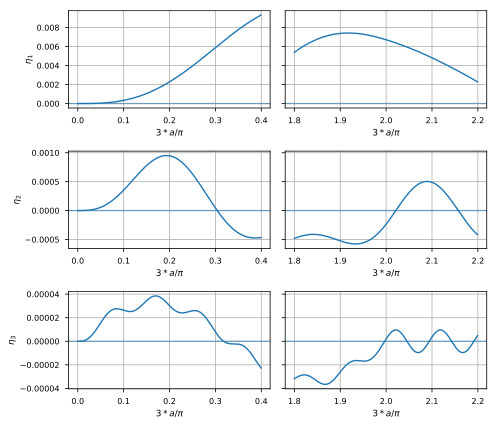

In [26]:
fig, axes = plt.subplots(Nfun-2, 2, sharey='row')
fig.set_figwidth(7)
fig.set_figheight(2*(Nfun-2))
ranges = [slice((2*nint)//30), slice((9*nint)//30, (11*nint)//30)]
ylabel = 1
for i in range(Nfun-2):
    for ax, rang in zip(axes[i], ranges):
        ax.plot(a[rang]*3/np.pi, etai[i,rang])
        ax.axhline(alpha=0.5)
        ax.set_xlabel('$3*a/\\pi$')
        if ylabel: ax.set_ylabel('$\\eta_{%d}$'%(i+1))
        ylabel = 1 - ylabel
plt.tight_layout()
#plt.savefig('grid.svg')
#plt.savefig('grid.pdf')
plt.show();

but of course what's really necessary is to plot all the responses, with the same scale

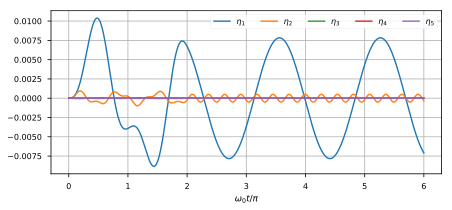

In [27]:
for i, line in enumerate(plt.plot(a*3/np.pi, etai.T), 1):
    line.set_label('$\eta_{%d}$'%i)
plt.legend(ncol=5)
plt.xlabel(r'$\omega_0t/\pi$')
#plt.savefig('figures/qs.pdf');
plt.show();

## Structural response

The letter of the problem requires a plot of $\sum_{i=1}^3\phi_i(l,
t)\,q_i(t)/\Delta_\text{st}$ and one of $-EJ\,\sum_{i=1}^3\phi''_i(0,
t)\,q_i(t)/(p_0L^2)$, here we make something better.  For each
quantity we produce a series of graphs where different approximations
(different partial sums of modal contributions) are compared, to have
a feeling of what's going on...

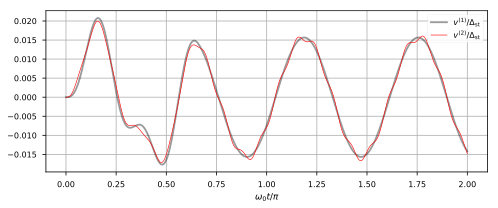

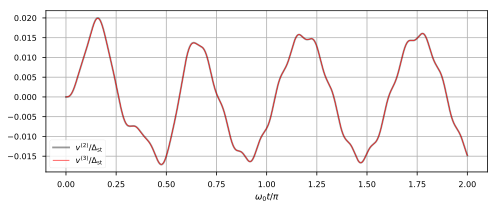

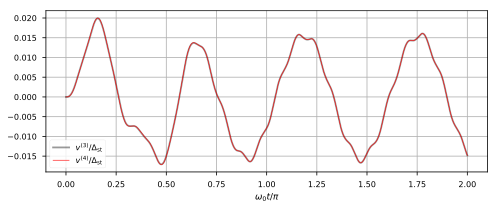

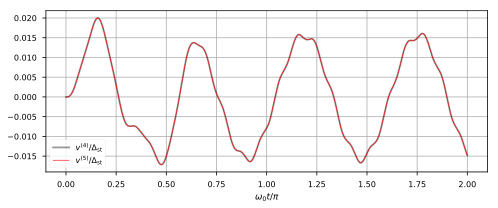

In [28]:
plot_cum(what=phi0s, position=1.0, fname='', # fname='vLt',
         label=r'$v^{(%d)}/\Delta_\mathrm{st}$',
         title=r'Tip displacements, $v^{(i)}(L,t) = \sum_1^i \phi_j(L)q_j(t)$')

It's apparent that $v^{(2)}(L,t)$ is a very good approximation to $v(L, t)$. What happens when we sum successive modal contributions to the base bending moments?

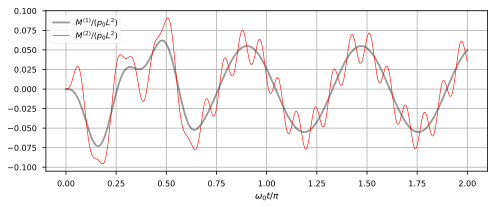

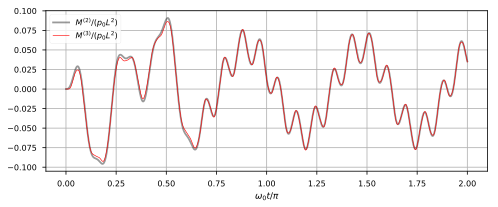

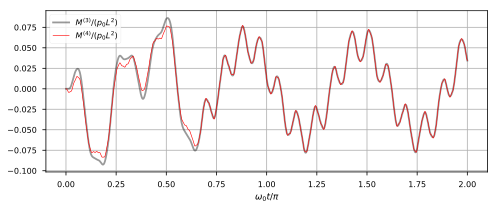

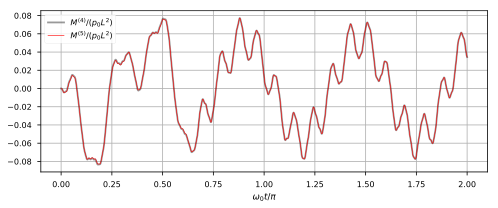

In [29]:
M = [-phi0s[i].diff(xi, 2) for i in range(Nfun)]
plot_cum(what=M, position=0.0,
         label=r'$M^{(%d)}/(p_0L^2)$', fname='M0t',
         title=r"Base bending moments, $M^{(i)}(0, t)=-EJ\sum_1^i\phi''_j(0)q_j(t)$")

In this second case, the contributions of the mode no. 4 is still relevant. 
#### Why  not the base shears?
after all, it's just a copy & paste plus a little edit...

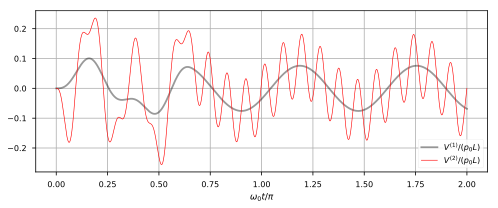

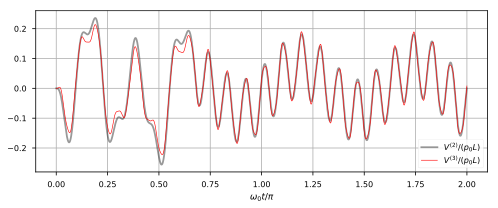

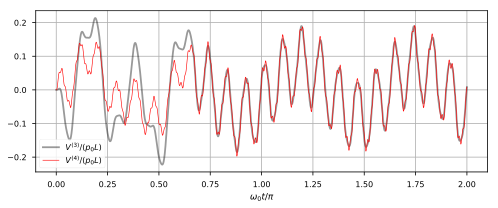

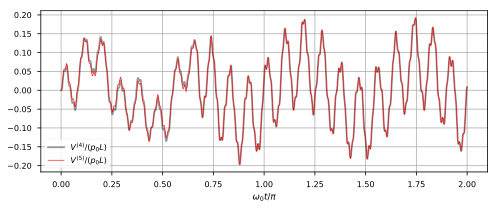

In [30]:
V = [-phi0s[i].diff(xi, 3) for i in range(Nfun)]
plot_cum(what=V, position=0.0,
         label=r'$V^{(%d)}/(p_0L)$', fname='V0t',
         title=r"Base shears, $V^{(i)}(0, t)=-EJ\sum_1^i\phi''_j(0)q_j(t)$")